# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, feature_selection, model_selection,metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
def load_starbuck_data(portfolio_path, profile_path, transcript_path):
    """
    Load JSON data from specified file paths into Pandas DataFrames.

    Parameters:
    portfolio_path (str): The file path to the portfolio JSON file.
    profile_path (str): The file path to the profile JSON file.
    transcript_path (str): The file path to the transcript JSON file.

    Returns:
    tuple: A tuple containing three Pandas DataFrames:
        - portfolio (DataFrame): DataFrame containing the portfolio data.
        - profile (DataFrame): DataFrame containing the profile data.
        - transcript (DataFrame): DataFrame containing the transcript data.

    Files:
    portfolio, profile, transcript = load_json_data('data/portfolio.json', 'data/profile.json', 'data/transcript.json')
    """
    portfolio = pd.read_json(portfolio_path, orient='records', lines=True)
    profile = pd.read_json(profile_path, orient='records', lines=True)
    transcript = pd.read_json(transcript_path, orient='records', lines=True)
    return portfolio, profile, transcript

# data loading
portfolio, profile, transcript = load_starbuck_data('data/portfolio.json', 'data/profile.json', 'data/transcript.json')


In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Portfolio Data cleaning

In [6]:
portfolio.shape

(10, 6)

In [7]:
def clean_portfolio_data(portfolio):
    """
    Clean the portfolio dataset by renaming columns, applying one-hot encoding to categorical columns,
    and dropping unnecessary columns.

    Parameters:
    portfolio (DataFrame): The original portfolio DataFrame containing the offer data.

    Returns:
    DataFrame: The cleaned portfolio DataFrame with one-hot encoded columns for channels and offer types.

    The cleaning process includes:
    - Creating a copy of the original DataFrame.
    - Renaming the 'id' column to 'offer_id'.
    - Applying one-hot encoding to the 'channels' column, creating separate columns for each channel.
    - Applying one-hot encoding to the 'offer_type' column and converting to integer type.
    - Dropping the original 'channels' and 'offer_type' columns.

    Example:
    portfolio_cleaned = clean_portfolio_data(portfolio)
    """
    # Create a copy of the DataFrame
    portfolio_cleaned = portfolio.copy()

    # Rename the 'id' column to 'offer_id'
    portfolio_cleaned = portfolio_cleaned.rename(columns={'id': 'offer_id'})

    # Apply one-hot encoding to the channels column
    channels_encoded = portfolio_cleaned['channels'].str.join('|').str.get_dummies()

    # Apply one-hot encoding to the offer_type column and convert to integer type
    offer_type_encoded = pd.get_dummies(portfolio_cleaned['offer_type']).astype(int)

    # Drop the original 'channels' and 'offer_type' columns
    portfolio_cleaned.drop(['channels', 'offer_type'], axis=1, inplace=True)

    # Merge the DataFrame with one-hot encoded columns
    portfolio_cleaned = pd.concat([portfolio_cleaned, channels_encoded, offer_type_encoded], axis=1)

    return portfolio_cleaned

# Cleaned portfolio
portfolio_cleaned = clean_portfolio_data(portfolio)
portfolio_cleaned.head(5)


,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [8]:
portfolio_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reward         10 non-null     int64 
 1   difficulty     10 non-null     int64 
 2   duration       10 non-null     int64 
 3   offer_id       10 non-null     object
 4   email          10 non-null     int64 
 5   mobile         10 non-null     int64 
 6   social         10 non-null     int64 
 7   web            10 non-null     int64 
 8   bogo           10 non-null     int32 
 9   discount       10 non-null     int32 
 10  informational  10 non-null     int32 
dtypes: int32(3), int64(7), object(1)
memory usage: 892.0+ bytes


In [9]:
portfolio_cleaned.duplicated().sum()

0

In [10]:
portfolio_cleaned.describe()

,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,1.0,0.900000,0.600000,0.800000,0.400000,0.400000,0.200000
std,3.583915,5.831905,2.321398,0.0,0.316228,0.516398,0.421637,0.516398,0.516398,0.421637
min,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,4.000000,8.500000,7.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


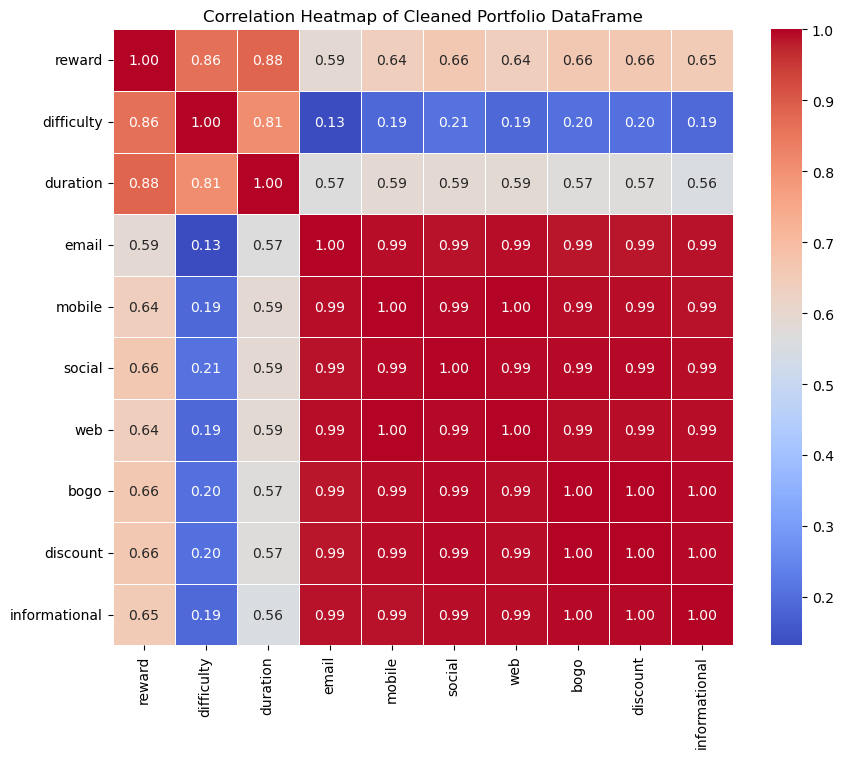

In [11]:
# Describe the cleaned portfolio DataFrame
portfolio_description = portfolio_cleaned.describe()

# Compute the correlation matrix
portfolio_correlation = portfolio_description.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(portfolio_correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Cleaned Portfolio DataFrame')
plt.show()

## Profile Data Cleaning

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [15]:
def preprocess_profile(profile):
    """
    Preprocess the profile dataset by performing various cleaning and transformation steps on the 'id', 'age', 'income', 'gender',
    and 'became_member_on' features.

    Parameters:
    profile (DataFrame): The original profile DataFrame containing customer data.

    Returns:
    DataFrame: The preprocessed profile DataFrame with necessary transformations applied.
    """

    # Rename 'id' column to 'customer_id' and rearrange columns
    profile = profile.rename(columns={'id': 'customer_id'})
    cols = list(profile.columns)
    cols.insert(0, cols.pop(cols.index('customer_id')))
    profile = profile[cols]

    # Replace 'customer_id' string values with numerical values
    profile['customer_id'] = profile['customer_id'].astype('category').cat.codes

    # Replace age = 118 with NaN and drop rows with NaN in 'age', 'gender', and 'income'
    profile['age'].replace(118, np.nan, inplace=True)
    profile.dropna(subset=['age', 'gender', 'income'], inplace=True)

    # Change the datatype of 'age' and 'income' to 'int'
    profile['age'] = profile['age'].astype(int)
    profile['income'] = profile['income'].astype(int)

    # Create 'age_group' and map to numerical labels
    def age_group(age):
        if age < 20:
            return 1  # Teenager
        elif age < 30:
            return 2  # Youth
        elif age < 60:
            return 3  # Mid-Age
        else:
            return 4  # Elder

    profile['age_group'] = profile['age'].apply(age_group)

    # Create 'income_range' and map to numerical labels
    def income_range(income):
        if income <= 60000:
            return 1  # Low-Income
        elif income <= 90000:
            return 2  # Mid-Income
        else:
            return 3  # High-Income

    profile['income_range'] = profile['income'].apply(income_range)

    # Replace 'gender' categorical labels with numerical labels
    gender_map = {'F': 1, 'M': 2, 'O': 3}
    profile['gender'] = profile['gender'].map(gender_map)

    # Change 'became_member_on' to datetime and create new columns
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    profile['start_year'] = profile['became_member_on'].dt.year
    profile['membership_days'] = (pd.Timestamp('today') - profile['became_member_on']).dt.days

    # Create 'member_type' and map to numerical labels
    def member_type(days):
        if days <= 2000:
            return 1  # Silver-Customer
        elif days <= 2600:
            return 2  # Bronze-Customer
        else:
            return 3  # Gold-Customer

    profile['member_type'] = profile['membership_days'].apply(member_type)

    # Drop unnecessary columns
    profile.drop(['age','became_member_on','membership_days'], axis=1, inplace=True)

    return profile

# Cleaned Profile 
profile_cleaned = preprocess_profile(profile)
print(profile_cleaned.head())


    customer_id  gender  income  age_group  income_range  start_year  \
1           398       1  112000          3             3        2017   
3          7996       1  100000          4             3        2017   
5         15043       2   70000          4             2        2018   
8          3728       2   53000          4             1        2018   
12         3059       2   51000          3             1        2017   

    member_type  
1             2  
3             2  
5             2  
8             2  
12            2  


In [16]:
profile_cleaned["income"].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

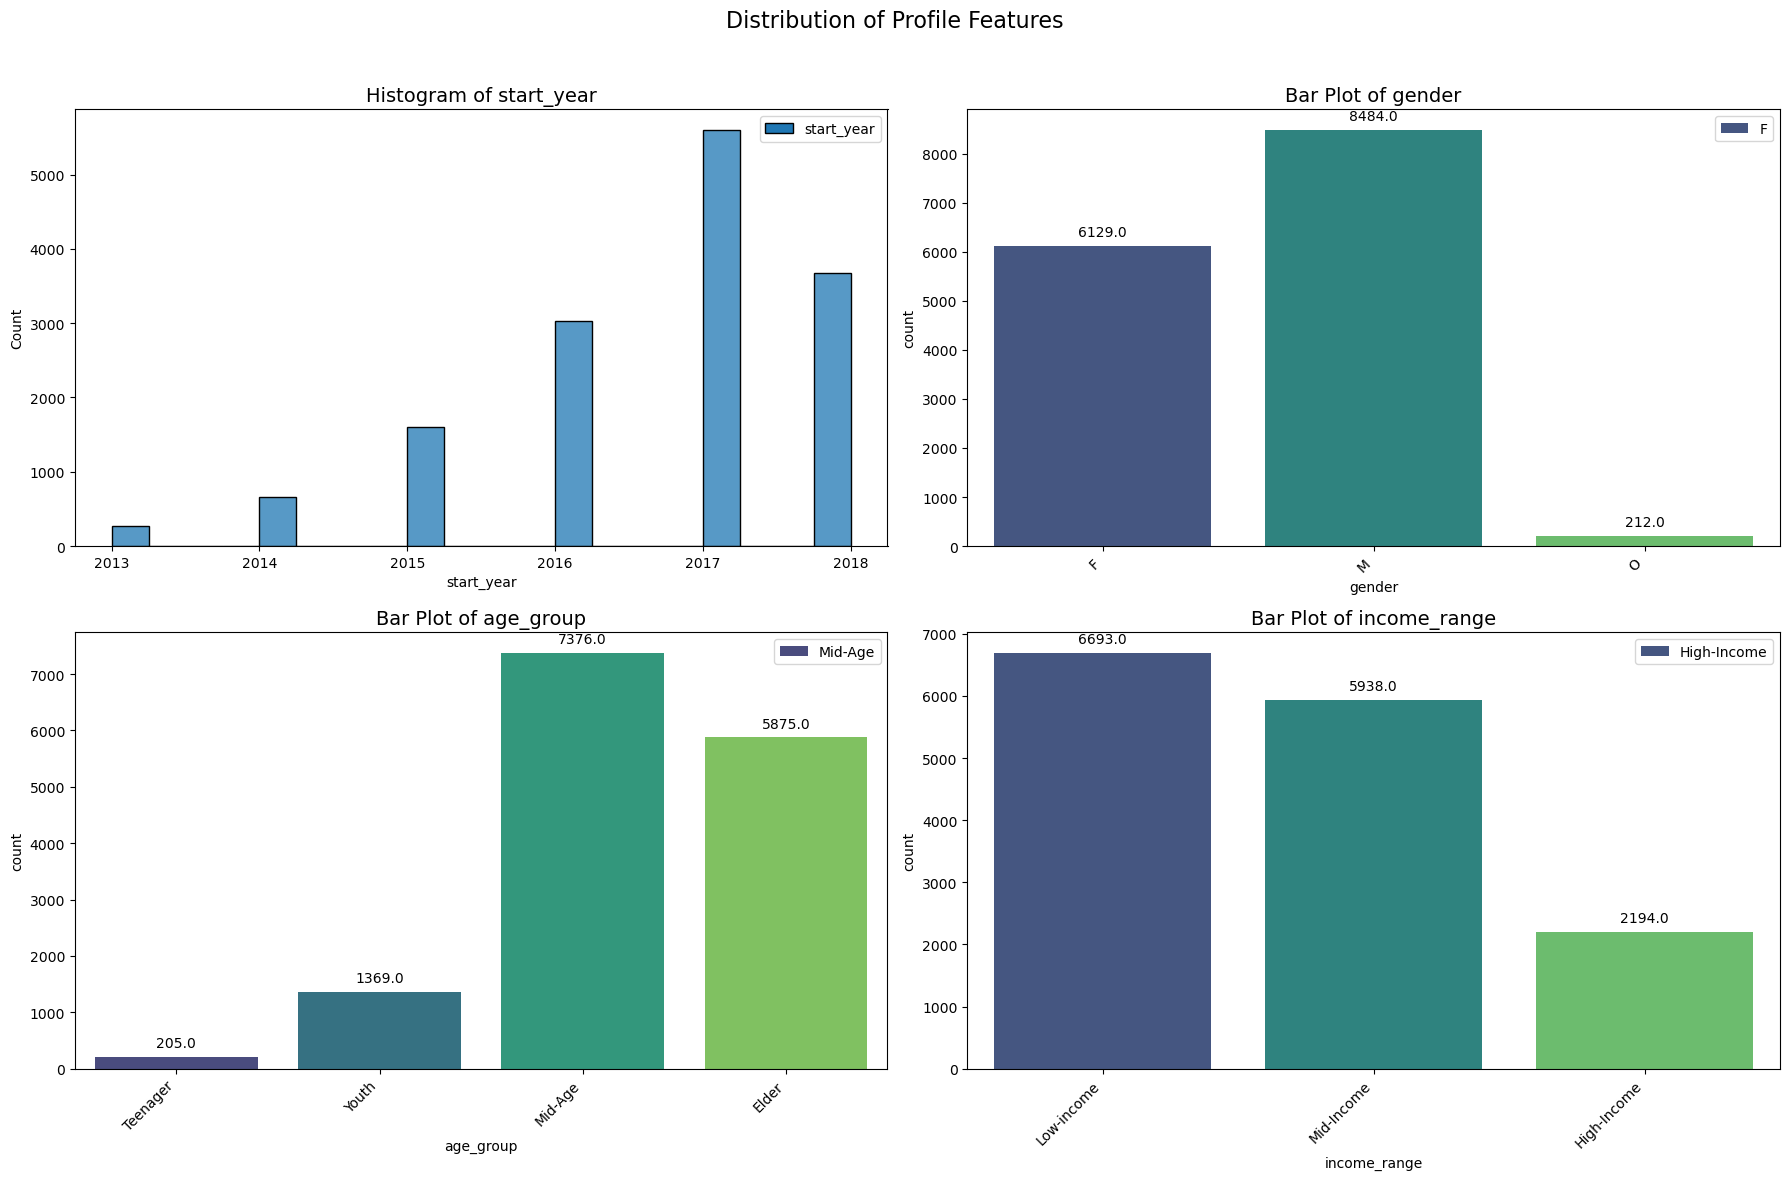

In [17]:
# Mapping for categorical labels
gender_map_rev = {1: 'F', 2: 'M', 3: 'O'}
age_group_map_rev = {1: 'Teenager', 2: 'Youth', 3: 'Mid-Age', 4: 'Elder'}
income_range_map_rev = {1: 'Low-income', 2: 'Mid-Income', 3: 'High-Income'}
member_type_map_rev = {1: 'Silver-Customer', 2: 'Bronze-Customer', 3: 'Gold-Customer'}

def plot_histograms_and_bars(df):
    """
    Plot histograms for numerical columns and bar plots for categorical columns in the DataFrame.

    Parameters:
    profile (DataFrame): The DataFrame containing the data to plot.
    """
    numeric_columns = ['start_year']
    categorical_columns = ['gender', 'age_group', 'income_range']

    # Calculate the number of subplots needed
    num_plots = len(numeric_columns) + len(categorical_columns)
    num_rows = (num_plots + 1) // 2  # Ensure at least enough rows to accommodate all plots

    fig, axes = plt.subplots(num_rows, 2, figsize=(18, 6 * num_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_columns):
        sns.histplot(df[col], bins=20, kde=False, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'Histogram of {col}', fontsize=14)
        axes[i].legend([col], loc='upper right')

    for i, col in enumerate(categorical_columns):
        ax = axes[i + len(numeric_columns)]
        sns.countplot(x=df[col], ax=ax, palette='viridis')
        ax.set_title(f'Bar Plot of {col}', fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        
        # Add data labels
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        # Replace numerical labels with categorical labels and add legend
        if col == 'gender':
            ax.set_xticklabels([gender_map_rev[int(label.get_text())] for label in ax.get_xticklabels()])
            ax.legend([gender_map_rev[v] for v in df[col].unique()], loc='upper right')
        elif col == 'age_group':
            ax.set_xticklabels([age_group_map_rev[int(label.get_text())] for label in ax.get_xticklabels()])
            ax.legend([age_group_map_rev[v] for v in df[col].unique()], loc='upper right')
        elif col == 'income_range':
            ax.set_xticklabels([income_range_map_rev[int(label.get_text())] for label in ax.get_xticklabels()])
            ax.legend([income_range_map_rev[v] for v in df[col].unique()], loc='upper right')

    plt.suptitle('Distribution of Profile Features', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Data Visualizations
plot_histograms_and_bars(profile_cleaned)


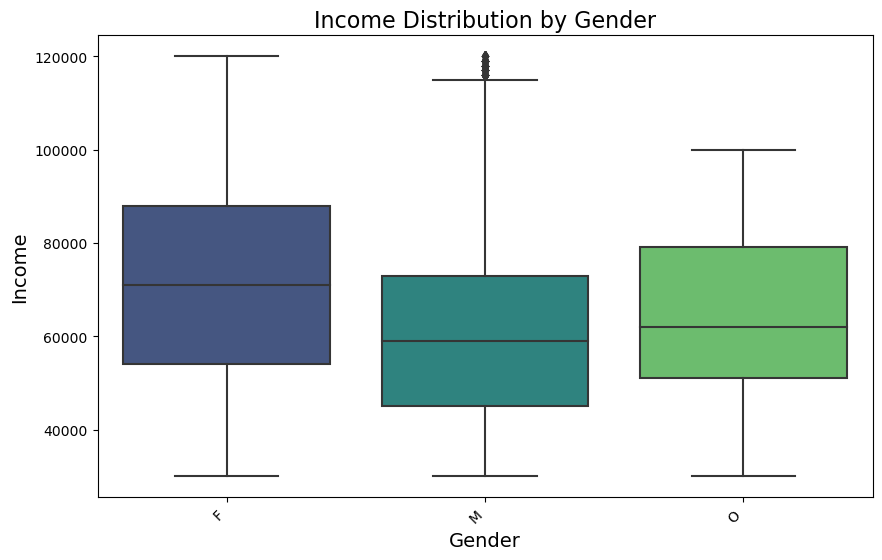

In [18]:
# Reverse mapping for gender to use in the plot
gender_map_rev = {1: 'F', 2: 'M', 3: 'O'}

# Adding a gender column with categorical labels
profile_cleaned['gender_label'] = profile_cleaned['gender'].map(gender_map_rev)

def plot_income_distribution_by_gender(df):
    """
    Plot the income distribution based on gender.

    Parameters:
    profile (DataFrame): The DataFrame containing the data to plot.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='gender_label', y='income', data=df, palette='viridis')
    plt.title('Income Distribution by Gender', fontsize=16)
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Income', fontsize=14)
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.show()

# Gender Income distribution visualization
plot_income_distribution_by_gender(profile_cleaned)


## Transcript Data Cleaning

In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
transcript["event"].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
def transcript_cleaned(transcript):
    """
    Preprocesses a copy of the transcript DataFrame by renaming columns, extracting 'offer id' from 'value' column,
    applying one-hot encoding to the 'event' column, and merging the DataFrame with one-hot encoded columns.

    Parameters:
    transcript (DataFrame): The DataFrame containing transcript data.

    Returns:
    DataFrame: The preprocessed transcript DataFrame.
    """
    # Make a copy of the transcript DataFrame
    transcript_copy = transcript.copy()

    # Rename 'person' column to 'customer_id'
    transcript_copy.rename(columns={'person': 'customer_id'}, inplace=True)

    # Extract 'offer id' from 'value' column and handle other types of value dictionaries
    def extract_offer_id(value):
        if 'offer id' in value:
            return value['offer id']
        elif 'offer_id' in value:
            return value['offer_id']
        return None
    
    transcript_copy['offer_id'] = transcript_copy['value'].apply(extract_offer_id)

    # Drop the 'value' column since it is no longer needed
    transcript_copy.drop(columns=['value'], inplace=True)

    # Apply one-hot encoding to the 'event' column
    transcript_encoded = pd.concat([transcript_copy, pd.get_dummies(transcript_copy['event'], prefix='event').astype(int)], axis=1)
    transcript_encoded.drop(columns=['event'], inplace=True)

    # Convert 'time' column to numerical data type
    transcript_encoded['time'] = transcript_encoded['time'].astype(float)

    # Replace 'customer_id' string values with numerical values
    transcript_encoded['customer_id'] = transcript_encoded['customer_id'].astype('category').cat.codes

    return transcript_encoded

# Cleaned transcript:
transcript_cleaned= transcript_cleaned(transcript)

# Display the first 6 rows
transcript_cleaned.head(6)


,customer_id,time,offer_id,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,7996,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,10735,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,15043,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,9524,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,6939,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
5,3728,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0


In [23]:
 transcript_cleaned['event_offer completed'].value_counts()

event_offer completed
0    272955
1     33579
Name: count, dtype: int64

In [24]:
transcript_cleaned.describe()

,customer_id,time,event_offer completed,event_offer received,event_offer viewed,event_transaction
count,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000
mean,8513.532424,366.382940,0.109544,0.248837,0.188315,0.453304
std,4915.310082,200.326314,0.312321,0.432340,0.390964,0.497815
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4247.250000,186.000000,0.000000,0.000000,0.000000,0.000000
50%,8522.000000,408.000000,0.000000,0.000000,0.000000,0.000000
75%,12773.000000,528.000000,0.000000,0.000000,0.000000,1.000000
max,16999.000000,714.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
def merge_data(transcript_cleaned, portfolio_cleaned, profile_cleaned):
    """
    Merge the transcript_cleaned, portfolio_cleaned and profile_cleaned DataFrames into one DataFrame.

    Parameters:
    transcript_cleaned (DataFrame): DataFrame containing cleaned transcript data.
    portfolio_cleaned (Dataframe): DataFrame containing cleaned portfolio data.
    profile_cleaned (DataFrame): DataFrame containing cleaned profile data.

    Returns:
    DataFrame: Merged DataFrame containing data from all input DataFrames.
    """
    # Merge clean_transcript with clean_portfolio on 'offer_id'
    merged_df = transcript_cleaned.merge(portfolio_cleaned, how='left', on='offer_id')
    
    # Merge the merged_df with clean_profile on 'customer_id'
    merged_df = merged_df.merge(profile_cleaned, how='left', on='customer_id')
    
    return merged_df

# Create one master dataframe:
master_df = merge_data(transcript_cleaned, portfolio_cleaned, profile_cleaned)

# Checking the newly created master dataset
master_df.head()


,customer_id,time,offer_id,event_offer completed,event_offer received,event_offer viewed,event_transaction,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,gender,income,age_group,income_range,start_year,member_type,gender_label
0,7996,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,100000.0,4.0,3.0,2017.0,2.0,F
1,10735,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15043,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,70000.0,4.0,2.0,2018.0,2.0,M
3,9524,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6939,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            306534 non-null  int16  
 1   time                   306534 non-null  float64
 2   offer_id               167581 non-null  object 
 3   event_offer completed  306534 non-null  int32  
 4   event_offer received   306534 non-null  int32  
 5   event_offer viewed     306534 non-null  int32  
 6   event_transaction      306534 non-null  int32  
 7   reward                 167581 non-null  float64
 8   difficulty             167581 non-null  float64
 9   duration               167581 non-null  float64
 10  email                  167581 non-null  float64
 11  mobile                 167581 non-null  float64
 12  social                 167581 non-null  float64
 13  web                    167581 non-null  float64
 14  bogo                   167581 non-nu

In [27]:
master_df.isna().sum()

customer_id                   0
time                          0
offer_id                 138953
event_offer completed         0
event_offer received          0
event_offer viewed            0
event_transaction             0
reward                   138953
difficulty               138953
duration                 138953
email                    138953
mobile                   138953
social                   138953
web                      138953
bogo                     138953
discount                 138953
informational            138953
gender                    33772
income                    33772
age_group                 33772
income_range              33772
start_year                33772
member_type               33772
gender_label              33772
dtype: int64

In [28]:
# Drop rows with all NaN values
master_df = master_df.dropna(how='all', axis=0)

### Business Questions

#### 1. What offers are mostly prefered by different Gender

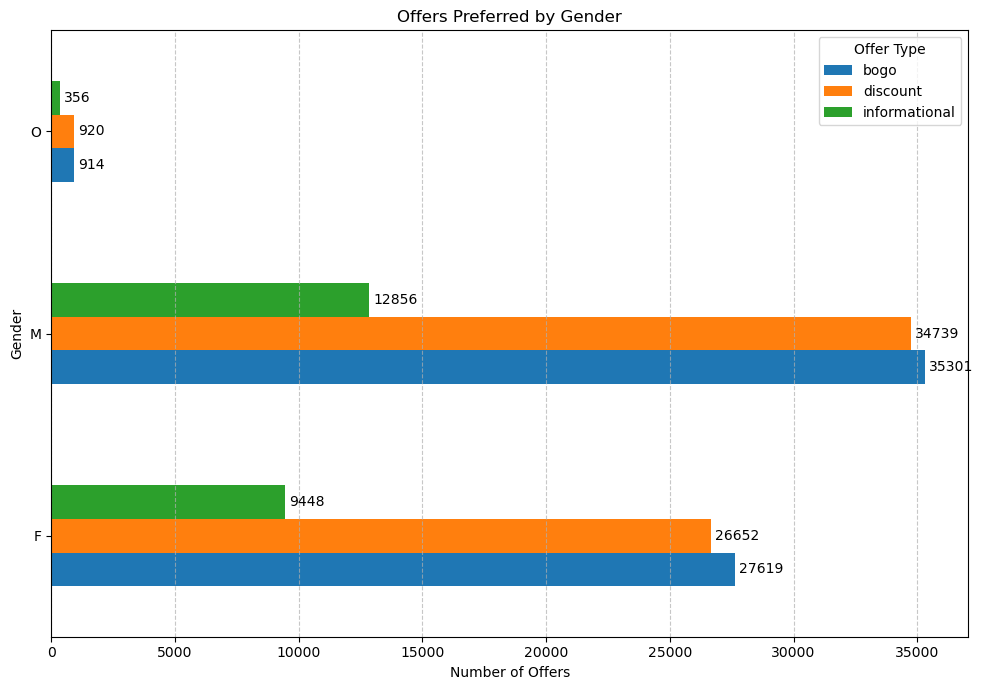

In [31]:
def analyze_offers_by_gender(df):
    """
    Analyze the offers preferred by gender.

    Parameters:
    df (DataFrame): The DataFrame containing the data.

    Returns:
    DataFrame: A DataFrame with the sum of each offer type per gender.
    """
    # Filter out the necessary columns and rows with non-null gender
    df_filtered = master_df[['gender_label', 'bogo', 'discount', 'informational']].dropna(subset=['gender_label'])
    
    # Group by gender and calculate the sum of each offer type
    offers_by_gender = df_filtered.groupby('gender_label').sum()

    return offers_by_gender

def plot_offers_by_gender(offers_by_gender):
    """
    Plot the offers preferred by gender.

    Parameters:
    offers_by_gender (DataFrame): DataFrame with the sum of each offer type per gender.
    """
    # Plotting the data
    ax = offers_by_gender.plot(kind='barh', figsize=(10, 7), stacked=False)
    
    plt.title('Offers Preferred by Gender')
    plt.xlabel('Number of Offers')
    plt.ylabel('Gender')
    plt.legend(title='Offer Type')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adding data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

    plt.tight_layout()
    plt.show()

# Data Visualization:
offers_by_gender_df = analyze_offers_by_gender(master_df)
plot_offers_by_gender(offers_by_gender_df)


#### 2.How does customer age group impact event outcome?

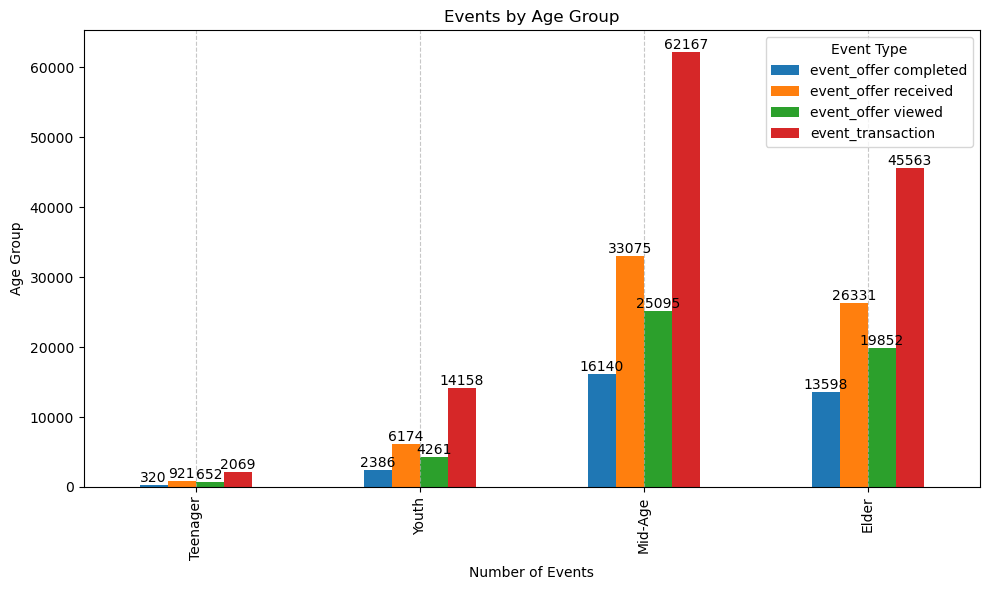

In [32]:
def analyze_events_by_age_group(df):
    """
    Analyze the impact of age group on events.

    Parameters:
    df (DataFrame): The DataFrame containing the data.

    Returns:
    DataFrame: A DataFrame with the sum of each event type per age group.
    """
    # Filter out the necessary columns and rows with non-null age_group
    df_filtered =master_df[['age_group', 'event_offer completed', 'event_offer received', 'event_offer viewed', 'event_transaction']].dropna(subset=['age_group'])
    
    # Group by age_group and calculate the sum of each event type
    events_by_age_group = df_filtered.groupby('age_group').sum()

    return events_by_age_group

def plot_events_by_age_group(events_by_age_group, age_group_map_rev):
    """
    Plot the events by age group with data labels, categorical labels, and a legend.

    Parameters:
    events_by_age_group (DataFrame): DataFrame with the sum of each event type per age group.
    age_group_map_rev (dict): Dictionary to map numerical age groups to categorical labels.
    """
    # Replace age group codes with categorical labels
    events_by_age_group.index = events_by_age_group.index.map(age_group_map_rev)

    # Plotting the data
    ax = events_by_age_group.plot(kind='bar', figsize=(10, 6), stacked=False)
    plt.title('Events by Age Group')
    plt.xlabel('Number of Events')
    plt.ylabel('Age Group')
    plt.legend(title='Event Type', loc='upper right')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Adding data labels
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')

    plt.tight_layout()
    plt.show()

#Visualization:
age_group_map_rev = {1: 'Teenager', 2: 'Youth', 3: 'Mid-Age', 4: 'Elder'}
events_by_age_group_df = analyze_events_by_age_group(master_df)
plot_events_by_age_group(events_by_age_group_df, age_group_map_rev)


#### 3. which channel guarantees higher conversion based on customer gender and age group?

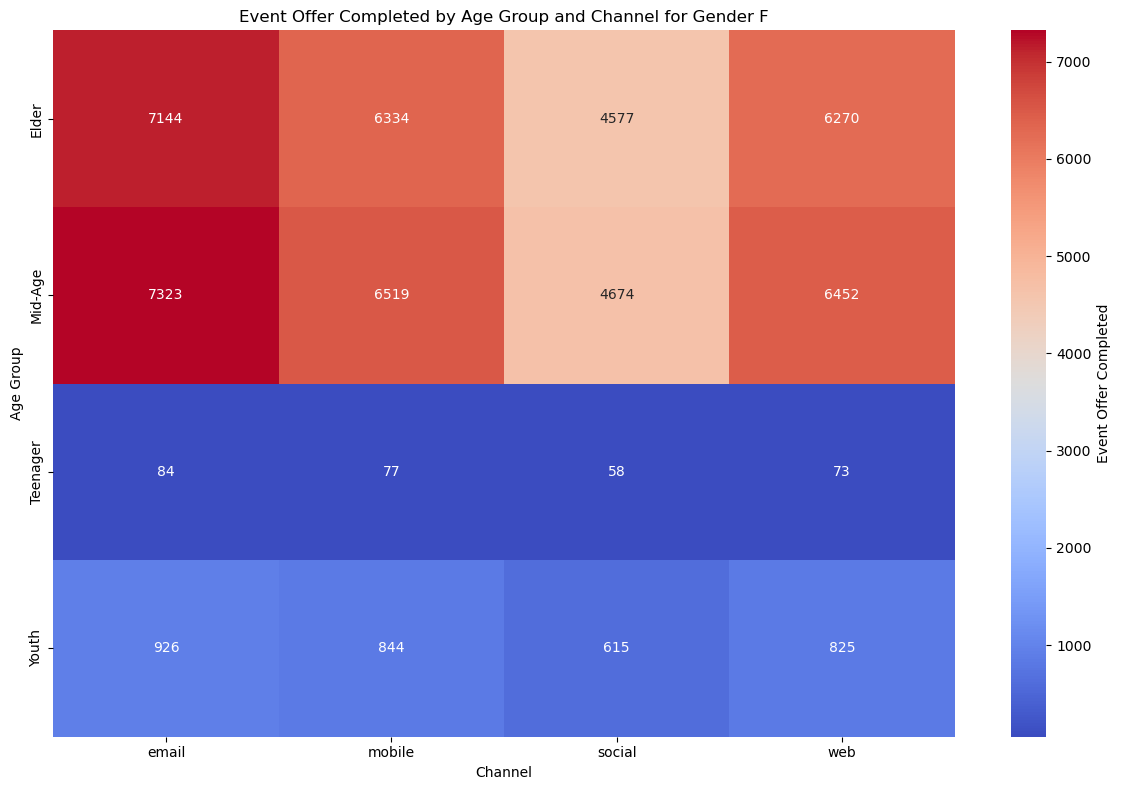

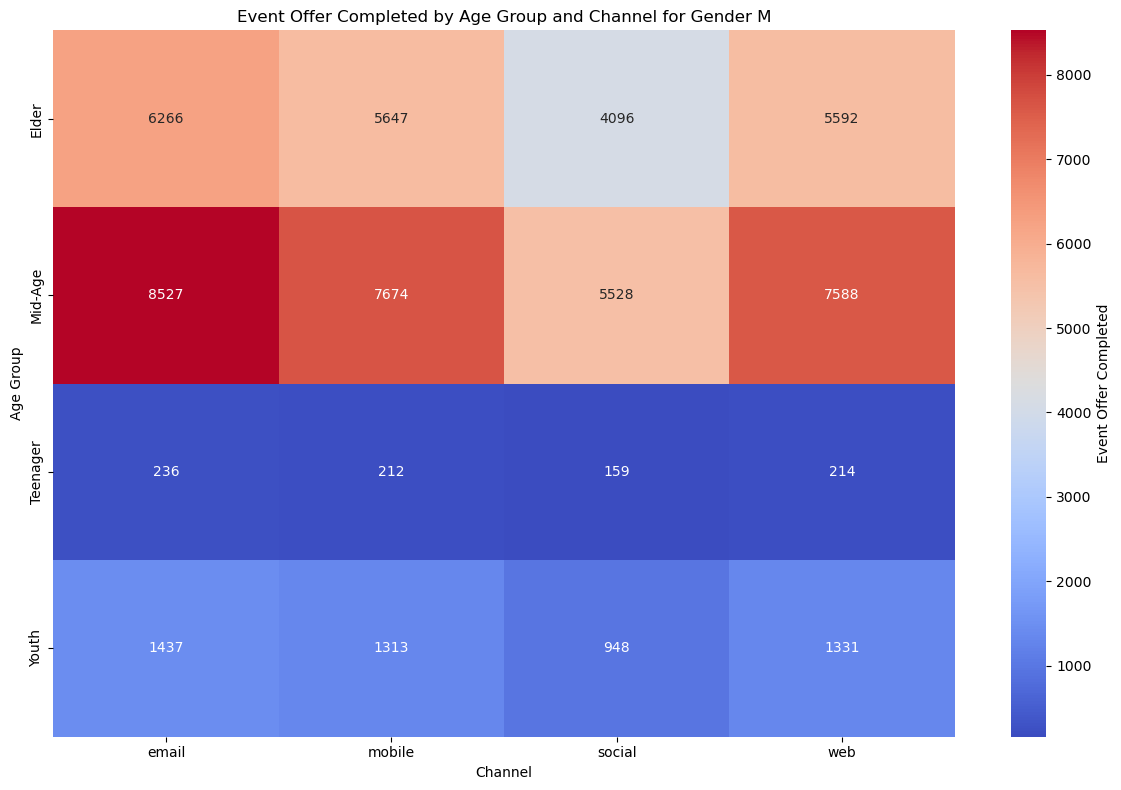

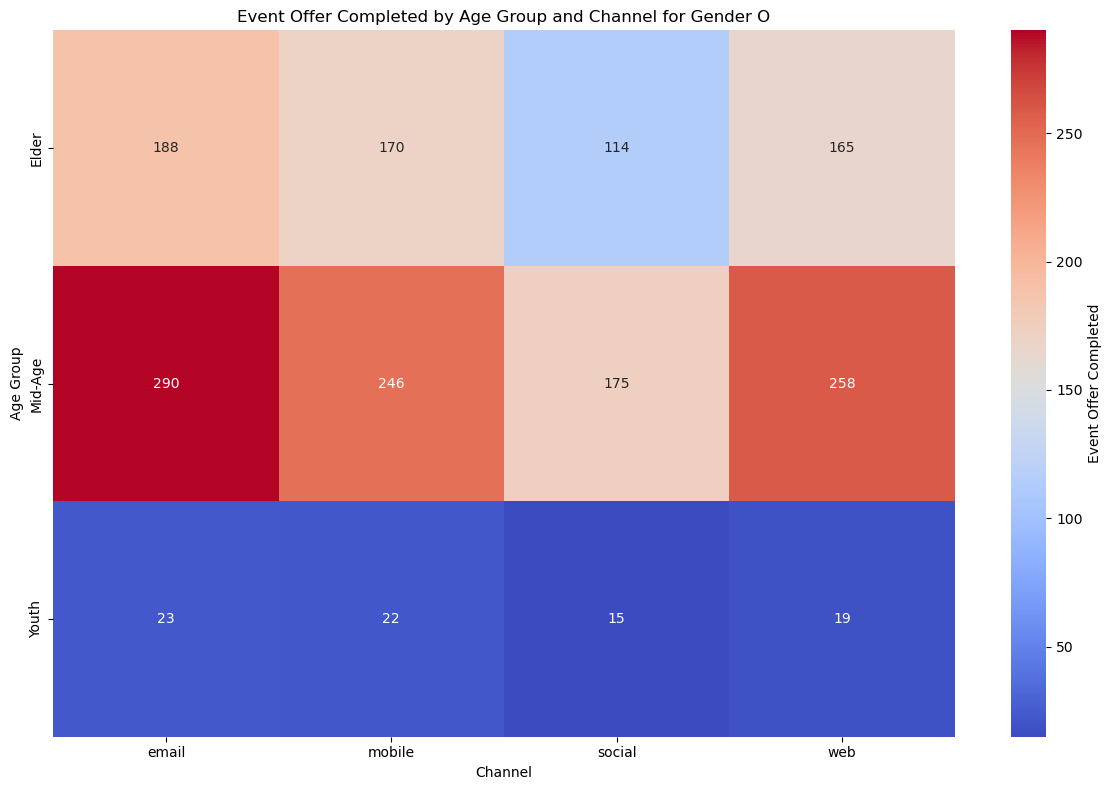

  channel  event_offer completed
0   email                  32444
1  mobile                  29058
3     web                  28787
2  social                  20959


In [33]:
def preprocess_data(master_df, age_group_map_rev, gender_map_rev):
    """
    Preprocess the data by filtering necessary columns and replacing numerical codes with categorical labels.
    
    Parameters:
    master_df (DataFrame): The DataFrame containing the data.
    age_group_map_rev (dict): Dictionary to map numerical age groups to categorical labels.
    gender_map_rev (dict): Dictionary to map numerical gender codes to categorical labels.
    
    Returns:
    DataFrame: The preprocessed DataFrame.
    """
    # Filter necessary columns and drop rows with NaN values in critical columns
    df_filtered = master_df[['age_group', 'gender', 'event_offer completed', 'email', 'mobile', 'social', 'web']].dropna(subset=['age_group', 'gender'])

    # Replace age group codes with categorical labels
    df_filtered['age_group'] = df_filtered['age_group'].map(age_group_map_rev)

    # Replace gender codes with categorical labels
    df_filtered['gender'] = df_filtered['gender'].map(gender_map_rev)

    return df_filtered

def melt_data(df_filtered):
    """
    Melt the DataFrame to create a multi-index DataFrame with age group, gender, and channel.
    
    Parameters:
    df_filtered (DataFrame): The preprocessed DataFrame.
    
    Returns:
    DataFrame: The melted DataFrame.
    """
    df_melted = pd.melt(df_filtered, id_vars=['age_group', 'gender', 'event_offer completed'], value_vars=['email', 'mobile', 'social', 'web'], var_name='channel', value_name='channel_flag')

    # Filter to include only the rows where the channel flag is 1 (indicating the channel was used)
    df_melted = df_melted[df_melted['channel_flag'] == 1]

    return df_melted

def group_and_summarize(df_melted):
    """
    Group by age group, gender, and channel, and calculate the sum of event_offer completed.
    
    Parameters:
    df_melted (DataFrame): The melted DataFrame.
    
    Returns:
    DataFrame: The grouped and summarized DataFrame.
    """
    channel_sums = df_melted.groupby(['age_group', 'gender', 'channel'])['event_offer completed'].sum().reset_index()
    return channel_sums

def plot_heatmap(channel_sums, gender):
    """
    Plot a heatmap to visualize the effect of different channels on event_offer completed by age group and gender.
    
    Parameters:
    channel_sums (DataFrame): DataFrame with the sum of event_offer completed per channel, age group, and gender.
    gender (str): Gender label ('F', 'M', 'O').
    """
    gender_data = channel_sums[channel_sums['gender'] == gender]
    heatmap_data = gender_data.pivot_table(index='age_group', columns='channel', values='event_offer completed', aggfunc='sum')

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='g')
    plt.title(f'Event Offer Completed by Age Group and Channel for Gender {gender}')
    plt.xlabel('Channel')
    plt.ylabel('Age Group')

    cbar = ax.collections[0].colorbar
    cbar.set_label('Event Offer Completed')

    plt.tight_layout()
    plt.show()

def determine_best_channel(channel_sums):
    """
    Determine the best channel for offer completion by summing the event_offer completed for each channel.
    
    Parameters:
    channel_sums (DataFrame): DataFrame with the sum of event_offer completed per channel, age group, and gender.
    
    Returns:
    DataFrame: A DataFrame showing the total event_offer completed for each channel.
    """
    channel_totals = channel_sums.groupby('channel')['event_offer completed'].sum().reset_index()
    channel_totals = channel_totals.sort_values(by='event_offer completed', ascending=False)
    return channel_totals

# Categorical data mapping:
age_group_map_rev = {1: 'Teenager', 2: 'Youth', 3: 'Mid-Age', 4: 'Elder'}
gender_map_rev = {1: 'F', 2: 'M', 3: 'O'}

# Preprocess data
df_filtered = preprocess_data(master_df, age_group_map_rev, gender_map_rev)

# Melt data
df_melted = melt_data(df_filtered)

# Group and summarize data
channel_sums_df = group_and_summarize(df_melted)

# Plot heatmap for each gender
for gender in ['F', 'M', 'O']:
    plot_heatmap(channel_sums_df, gender)

# Determine the best channel
best_channel_df = determine_best_channel(channel_sums_df)
print(best_channel_df)


#### 4. What is the relationship between income level, offer_type and offer_completion

In [34]:
def get_offer_type_counts(master_df):
    """
    Get the unique counts of each offer type.
    
    Parameters:
    master_df (DataFrame): The DataFrame containing the data.
    
    Returns:
    DataFrame: A DataFrame with the unique counts of each offer type.
    """
    offer_types = ['bogo', 'discount', 'informational']
    offer_counts = {}

    for offer in offer_types:
        offer_counts[offer] = master_df[offer].sum()

    offer_counts_df = pd.DataFrame(list(offer_counts.items()), columns=['Offer Type', 'Count'])
    return offer_counts_df

# Offer type counts:
offer_counts_df = get_offer_type_counts(master_df)
print(offer_counts_df)

      Offer Type    Count
0           bogo  71617.0
1       discount  69898.0
2  informational  26066.0


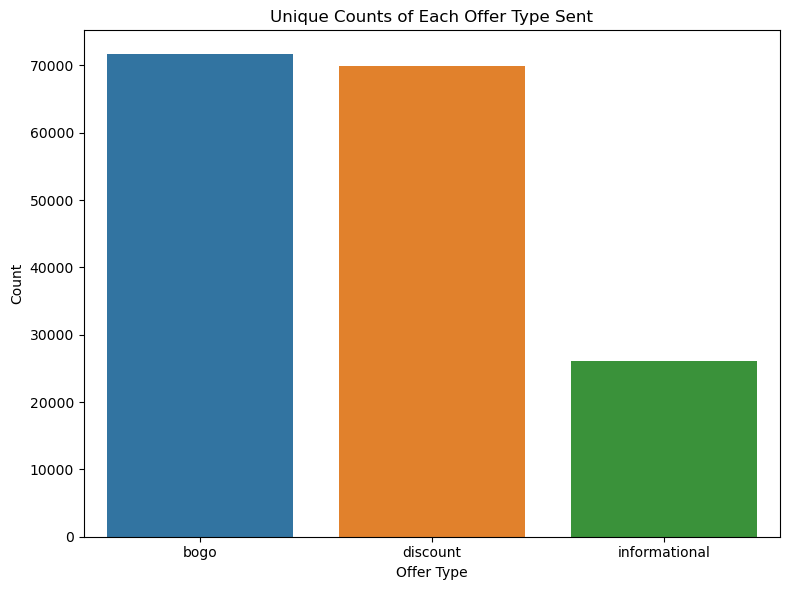

In [35]:
def plot_offer_type_counts(offer_counts_df):
    """
    Plot a bar chart for the offer type counts.
    
    Parameters:
    offer_counts_df (DataFrame): The DataFrame with the unique counts of each offer type.
    """
    plt.figure(figsize=(8, 6))
    sns.barplot(data=offer_counts_df, x='Offer Type', y='Count')
    plt.title('Unique Counts of Each Offer Type Sent')
    plt.xlabel('Offer Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Plot the offer type counts
plot_offer_type_counts(offer_counts_df)


Filtered Data:
  income_range  bogo  discount  informational  event_offer completed
0         High   1.0       0.0            0.0                      0
2       Medium   0.0       1.0            0.0                      0
5          Low   1.0       0.0            0.0                      0
7          Low   0.0       0.0            1.0                      0
8          Low   0.0       1.0            0.0                      0
Melted Data:
   income_range  event_offer completed offer_type  offer_flag
0          High                      0       bogo         1.0
2           Low                      0       bogo         1.0
6          High                      0       bogo         1.0
11          Low                      0       bogo         1.0
12       Medium                      0       bogo         1.0
Grouped and Summarized Data:
  income_range     offer_type  event_offer completed
0         High           bogo                   2975
1         High       discount                   303

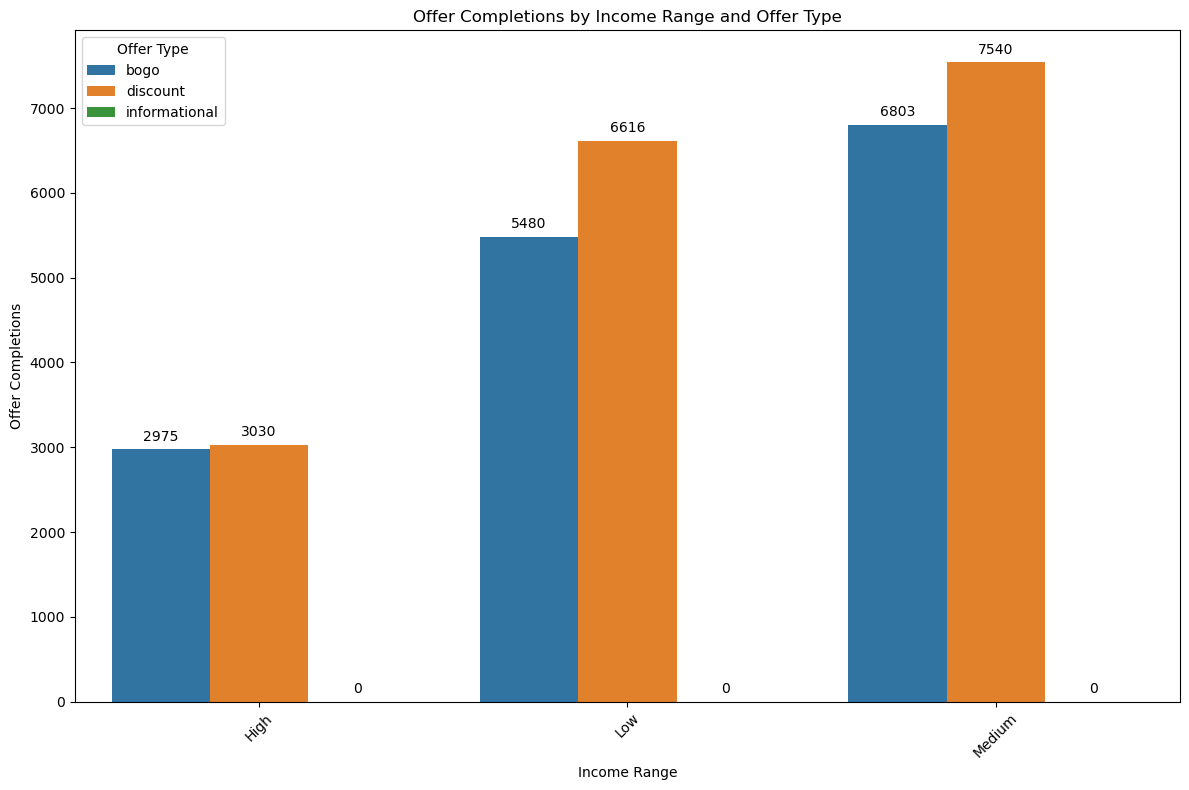

In [36]:
def preprocess_data_for_analysis(master_df, income_group_map):
    """
    Preprocess the data by filtering necessary columns and replacing numerical codes with categorical labels.
    
    Parameters:
    master_df (DataFrame): The DataFrame containing the data.
    income_group_map (dict): Dictionary to map numerical income groups to categorical labels.
    
    Returns:
    DataFrame: The preprocessed DataFrame.
    """
    # Filter necessary columns and drop rows with NaN values in critical columns
    df_filtered = master_df[['income_range', 'bogo', 'discount', 'informational', 'event_offer completed']].dropna(subset=['income_range'])

    # Replace income group codes with categorical labels
    df_filtered['income_range'] = df_filtered['income_range'].map(income_group_map)

    return df_filtered

def melt_offer_types(df_filtered):
    """
    Melt the DataFrame to create a multi-index DataFrame with income range, offer type, and offer completion.
    
    Parameters:
    df_filtered (DataFrame): The preprocessed DataFrame.
    
    Returns:
    DataFrame: The melted DataFrame.
    """
    df_melted = pd.melt(df_filtered, id_vars=['income_range', 'event_offer completed'], value_vars=['bogo', 'discount', 'informational'], var_name='offer_type', value_name='offer_flag')

    # Filter to include only the rows where the offer flag is 1 (indicating the offer type)
    df_melted = df_melted[df_melted['offer_flag'] == 1]

    return df_melted

def group_and_summarize_offers(df_melted):
    """
    Group by income range and offer type, and calculate the sum of event_offer completed.
    
    Parameters:
    df_melted (DataFrame): The melted DataFrame.
    
    Returns:
    DataFrame: The grouped and summarized DataFrame.
    """
    offer_sums = df_melted.groupby(['income_range', 'offer_type'])['event_offer completed'].sum().reset_index()
    return offer_sums

def plot_offer_completion_by_income_and_type(offer_sums):
    """
    Plot bar charts to visualize offer completions by income range and offer type, with data labels.
    
    Parameters:
    offer_sums (DataFrame): DataFrame with the sum of event_offer completed per income range and offer type.
    """
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=offer_sums, x='income_range', y='event_offer completed', hue='offer_type')

    # Add data labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.title('Offer Completions by Income Range and Offer Type')
    plt.xlabel('Income Range')
    plt.ylabel('Offer Completions')
    plt.legend(title='Offer Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Data Mapping:
income_group_map = {1: 'Low', 2: 'Medium', 3: 'High'} 

# Preprocess data
df_filtered = preprocess_data_for_analysis(master_df, income_group_map)

# Validate intermediate results
print("Filtered Data:")
print(df_filtered.head())

# Melt data to separate offer types
df_melted = melt_offer_types(df_filtered)

# Validate intermediate results
print("Melted Data:")
print(df_melted.head())

# Group and summarize the data by income range and offer type
offer_sums_df = group_and_summarize_offers(df_melted)

# Validate intermediate results
print("Grouped and Summarized Data:")
print(offer_sums_df.head())

# Plot the offer completion by income range and offer type
plot_offer_completion_by_income_and_type(offer_sums_df)


## MODEL

In [37]:
def prepare_data_for_xgboost(master_df):
    """
    Prepare the data for training an XGBoost classifier.
    
    Parameters:
    master_df (DataFrame): The DataFrame containing the data.
    
    Returns:
    X_train, X_test, y_train, y_test: The split data ready for training and testing.
    """
    # Select relevant features and target variable
    features = ['time', 'offer_id', 'reward', 'difficulty', 'duration', 'email', 
                'mobile', 'social', 'web', 'bogo', 'discount', 'informational', 
                'gender_label', 'income_range', 'age_group']
    
    target = 'event_offer completed'
    
    # Filter the dataframe to include only the selected features and target
    df_filtered = master_df[features + [target]].dropna()
    
    # Encode categorical variables
    label_encoders = {}
    for column in ['offer_id', 'gender_label', 'income_range', 'age_group']:
        le = LabelEncoder()
        df_filtered[column] = le.fit_transform(df_filtered[column])
        label_encoders[column] = le
    
    # Define X and y
    X = df_filtered[features]
    y = df_filtered[target]
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoders

def train_xgboost_classifier(X_train, y_train):
    """
    Train an XGBoost classifier.
    
    Parameters:
    X_train (DataFrame): The training features.
    y_train (Series): The training target variable.
    
    Returns:
    model: The trained XGBoost classifier.
    """
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained XGBoost classifier.
    
    Parameters:
    model: The trained XGBoost classifier.
    X_test (DataFrame): The test features.
    y_test (Series): The test target variable.
    
    Returns:
    None
    """
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Example usage:

# Prepare the data
X_train, X_test, y_train, y_test, label_encoders = prepare_data_for_xgboost(master_df)

# Train the classifier
model = train_xgboost_classifier(X_train, y_train)

# Evaluate the model
evaluate_model(model, X_test, y_test)


Accuracy: 0.8305500487214811
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     23285
           1       0.62      0.57      0.59      6476

    accuracy                           0.83     29761
   macro avg       0.75      0.74      0.74     29761
weighted avg       0.83      0.83      0.83     29761



In [38]:
def preprocess_data_for_analysis(master_df, income_group_map):
    """
    Preprocess the data by filtering necessary columns and replacing numerical codes with categorical labels.
    
    Parameters:
    master_df (DataFrame): The DataFrame containing the data.
    income_group_map (dict): Dictionary to map numerical income groups to categorical labels.
    
    Returns:
    DataFrame: The preprocessed DataFrame.
    """
    # Filter necessary columns and drop rows with NaN values in critical columns
    df_filtered = master_df[['income_range', 'bogo', 'discount', 'informational', 'event_offer completed', 'time', 'offer_id', 'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'gender_label', 'age_group']].dropna(subset=['income_range'])

    # Replace income group codes with categorical labels
    df_filtered['income_range'] = df_filtered['income_range'].map(income_group_map)

    return df_filtered

def encode_features(df):
    """
    Encode categorical features using LabelEncoder.
    
    Parameters:
    df (DataFrame): The DataFrame to be encoded.
    
    Returns:
    DataFrame: The encoded DataFrame.
    dict: Dictionary of label encoders.
    """
    label_encoders = {}
    for column in ['offer_id', 'gender_label', 'income_range', 'age_group']:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

def train_xgboost_classifier(X_train, y_train):
    """
    Train an XGBoost classifier with class weighting.
    
    Parameters:
    X_train (DataFrame): The training features.
    y_train (Series): The training target variable.
    
    Returns:
    model: The trained XGBoost classifier.
    """
    class_weights = {0: 1, 1: (y_train == 0).sum() / (y_train == 1).sum()}
    model = XGBClassifier(scale_pos_weight=class_weights[1], use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained XGBoost classifier.
    
    Parameters:
    model: The trained XGBoost classifier.
    X_test (DataFrame): The test features.
    y_test (Series): The test target variable.
    
    Returns:
    None
    """
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Example usage:

# Define the income group map
income_group_map = {1: 'Low', 2: 'Medium', 3: 'High'}  

# Preprocess data
df_filtered = preprocess_data_for_analysis(master_df, income_group_map)

# Encode categorical features
df_encoded, label_encoders = encode_features(df_filtered)

# Define features and target variable
X = df_encoded.drop('event_offer completed', axis=1)
y = df_encoded['event_offer completed']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier with class weighting
model = train_xgboost_classifier(X_train, y_train)

# Evaluate the model
evaluate_model(model, X_test, y_test)


Accuracy: 0.877861895771085
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93     48082
           1       0.49      0.91      0.64      6471

    accuracy                           0.88     54553
   macro avg       0.74      0.89      0.78     54553
weighted avg       0.93      0.88      0.89     54553



It seems like the model has achieved a high accuracy of approximately 87.79%. However, looking at the classification report, there are some observations to consider:

Precision: For class 1 (event_offer completed), the precision is 49%, indicating that out of all the instances predicted as offer completion, only 49% are correct. This suggests that there might be some false positives in the predictions.

Recall: The recall for class 1 is 91%, which means that out of all the actual offer completions, the model correctly identifies 91% of them. This indicates that the model is good at capturing instances of offer completions.

F1-score: The F1-score, which is the harmonic mean of precision and recall, is 64% for class 1. This metric provides a balance between precision and recall.

Support: Class 0 (no offer completion) has a much larger support (number of instances) compared to class 1, indicating class imbalance.

Overall: The weighted average of precision, recall, and F1-score is around 88%, suggesting good overall performance. However, it's essential to consider the imbalance in the classes, especially if the goal is to accurately predict offer completions.

Based on this report, while the model performs well overall, there might be room for improvement, especially in terms of precision for class 1. Depending on the specific use case and the importance of correctly predicting offer completions, further optimization or exploration of different modeling techniques may be warranted.

In [39]:
def preprocess_data_for_analysis(master_df, income_group_map):
    """
    Preprocess the data by filtering necessary columns and replacing numerical codes with categorical labels.
    
    Parameters:
    master_df (DataFrame): The DataFrame containing the data.
    income_group_map (dict): Dictionary to map numerical income groups to categorical labels.
    
    Returns:
    DataFrame: The preprocessed DataFrame.
    """
    df_filtered = master_df[['income_range', 'bogo', 'discount', 'informational', 
                             'event_offer completed', 'time', 'offer_id', 'reward', 
                             'difficulty', 'duration', 'email', 'mobile', 'social', 
                             'web', 'gender_label', 'age_group']].dropna(subset=['income_range'])

    df_filtered['income_range'] = df_filtered['income_range'].map(income_group_map)

    return df_filtered

def encode_features(df):
    """
    Encode categorical features using LabelEncoder.
    
    Parameters:
    df (DataFrame): The DataFrame to be encoded.
    
    Returns:
    DataFrame: The encoded DataFrame.
    dict: Dictionary of label encoders.
    """
    label_encoders = {}
    for column in ['offer_id', 'gender_label', 'income_range', 'age_group']:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

def train_xgboost_classifier(X_train, y_train):
    """
    Train an XGBoost classifier.
    
    Parameters:
    X_train (DataFrame): The training features.
    y_train (Series): The training target variable.
    
    Returns:
    model: The trained XGBoost classifier.
    """
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [100, 200, 300]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    model.set_params(**best_params)
    
    model.fit(X_train, y_train)
    
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained XGBoost classifier.
    
    Parameters:
    model: The trained XGBoost classifier.
    X_test (DataFrame): The test features.
    y_test (Series): The test target variable.
    
    Returns:
    None
    """
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Example usage:

income_group_map = {1: 'Low', 2: 'Medium', 3: 'High'}  

# Preprocess data
df_filtered = preprocess_data_for_analysis(master_df, income_group_map)

# Encode categorical features
df_encoded, label_encoders = encode_features(df_filtered)

# Define features and target variable
X = df_encoded.drop('event_offer completed', axis=1)
y = df_encoded['event_offer completed']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier with hyperparameter tuning
model = train_xgboost_classifier(X_train, y_train)

# Evaluate the model
evaluate_model(model, X_test, y_test)


Accuracy: 0.9099957839165582
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     48082
           1       0.64      0.56      0.60      6471

    accuracy                           0.91     54553
   macro avg       0.79      0.76      0.77     54553
weighted avg       0.91      0.91      0.91     54553



The model's accuracy has improved to around 91%, indicating a significant enhancement in performance.

For the negative class (event_offer completed = 0), precision and recall are quite high, indicating that the model effectively identifies instances where the offer is not completed and rarely misclassifies completed offers as incomplete.

However, for the positive class (event_offer completed = 1), while precision has increased, recall has slightly decreased compared to the previous model. This suggests that the model is more cautious in predicting positive cases, resulting in fewer false positives but also missing some true positives.

In essence, this model achieves a good balance between precision and recall, ensuring reliable predictions for both classes. Fine-tuning the hyperparameters through grid search has notably optimized the model's performance.

In [40]:
def preprocess_data_for_analysis(master_df, income_group_map):
    df_filtered = master_df[['customer_id', 'income_range', 'bogo', 'discount', 'informational', 
                             'event_offer completed', 'time', 'offer_id', 'reward', 'difficulty', 
                             'duration', 'email', 'mobile', 'social', 'web', 'gender_label', 'age_group']].dropna(subset=['income_range'])

    df_filtered['income_range'] = df_filtered['income_range'].map(income_group_map)

    # Extracting time-based features
    df_filtered['hour'] = df_filtered['time'] % 24
    df_filtered['day'] = (df_filtered['time'] // 24) % 7
    df_filtered['month'] = (df_filtered['time'] // (24 * 30)) % 12
    
    return df_filtered

def create_additional_features(df):
    # Interaction terms
    df['reward_difficulty_ratio'] = df['reward'] / (df['difficulty'] + 1)
    df['duration_difficulty_ratio'] = df['duration'] / (df['difficulty'] + 1)

    # Aggregated customer data
    customer_offer_counts = df.groupby('customer_id').size().reset_index(name='customer_offer_count')
    df = df.merge(customer_offer_counts, on='customer_id', how='left')

    # Behavioral features
    df['time_since_last_offer'] = df.groupby('customer_id')['time'].diff().fillna(0)
    
    # Historical completion rate
    completion_rate = df.groupby('customer_id')['event_offer completed'].mean().reset_index(name='historical_completion_rate')
    df = df.merge(completion_rate, on='customer_id', how='left')

    return df

def encode_features(df):
    label_encoders = {}
    for column in ['offer_id', 'gender_label', 'income_range', 'age_group']:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

def train_xgboost_classifier(X_train, y_train):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [100, 200, 300]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    model.set_params(**best_params)
    
    model.fit(X_train, y_train)
    
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Example usage:

income_group_map = {1: 'Low', 2: 'Medium', 3: 'High'}  

# Preprocess data
df_filtered = preprocess_data_for_analysis(master_df, income_group_map)

# Create additional features
df_enhanced = create_additional_features(df_filtered)

# Encode categorical features
df_encoded, label_encoders = encode_features(df_enhanced)

# Define features and target variable
X = df_encoded.drop('event_offer completed', axis=1)
y = df_encoded['event_offer completed']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier with hyperparameter tuning
model = train_xgboost_classifier(X_train, y_train)

# Evaluate the model
evaluate_model(model, X_test, y_test)

Accuracy: 0.9901930232984437
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     48082
           1       0.99      0.93      0.96      6471

    accuracy                           0.99     54553
   macro avg       0.99      0.96      0.98     54553
weighted avg       0.99      0.99      0.99     54553



The new accuracy and classification report indicate a significant improvement in your model's performance. The added features have enhanced the model's ability to predict offer completions. Here's a summary of what was done and why these changes helped:

Feature Engineering Summary:
Interaction Terms:

reward_difficulty_ratio: Captures the relative difficulty of an offer in relation to its reward.
duration_difficulty_ratio: Captures the relative difficulty of an offer in relation to its duration.
Time-based Features:

hour, day, month: Extracted from the time feature to capture temporal patterns in customer behavior.
Aggregated Customer Data:

customer_offer_count: Total number of offers a customer has received.
Behavioral Features:

time_since_last_offer: The time difference between consecutive offers received by the same customer.
Historical Offer Completion Rate:

historical_completion_rate: The historical completion rate of offers for each customer.
Model Evaluation Summary:
Accuracy: Increased to 99.02%, indicating the model's overall improved performance.
Precision and Recall for class 1 (offer completed) improved significantly, showing better identification of positive cases.


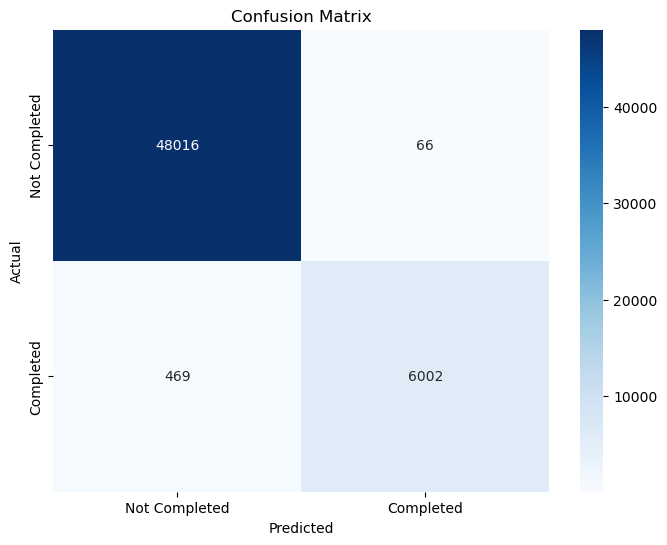

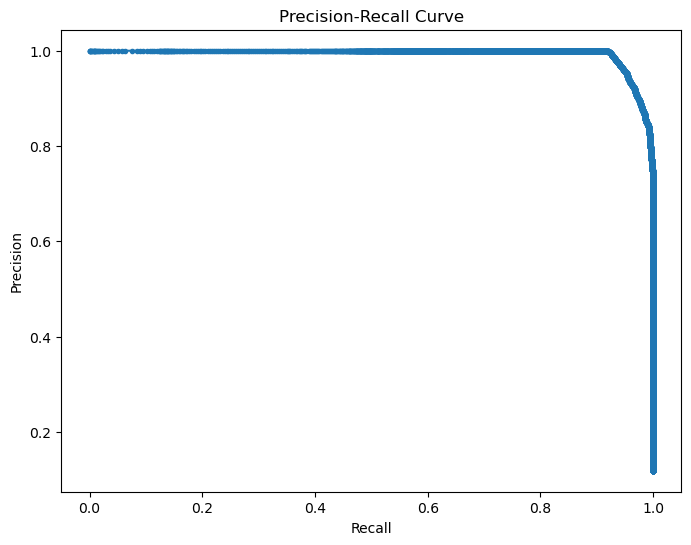

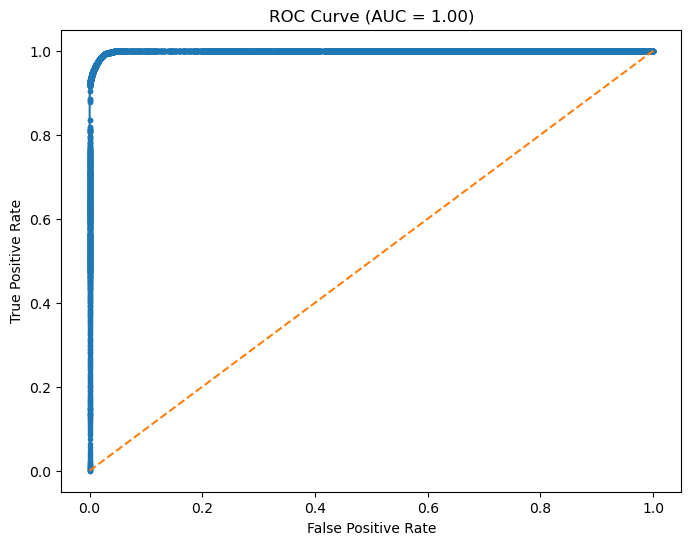

In [41]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Completed', 'Completed'], yticklabels=['Not Completed', 'Completed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_precision_recall_curve(y_test, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
    plt.show()

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred)

# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test, y_pred_proba)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba)


In [42]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.97105567 0.97134896 0.95199076 0.96315442 0.97275994]
Mean cross-validation score: 0.9660619504156254


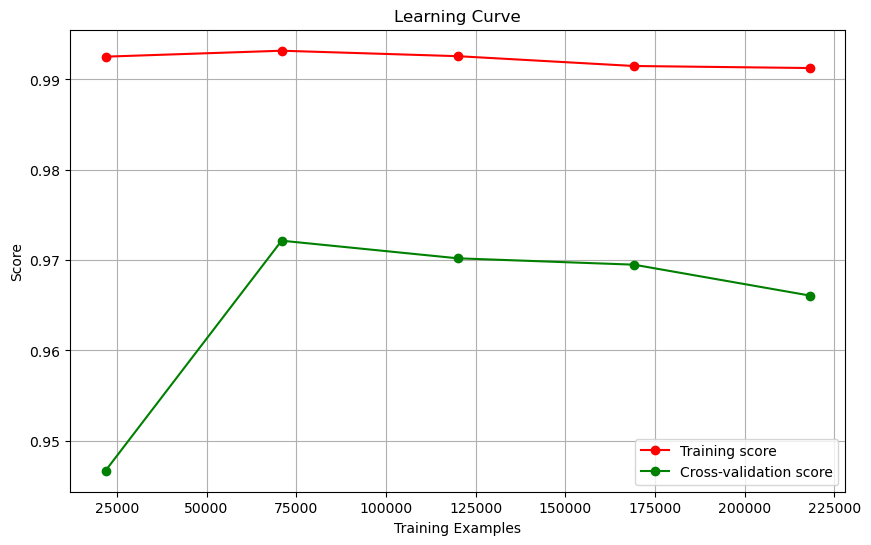

In [43]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curve
plot_learning_curve(model, X, y)
